# Assignment 4 - Predicting and understanding viewer engagement with educational videos 

With the accelerating popularity of online educational experiences, the role of online lectures and other educational video continues to increase in scope and importance. Open access educational repositories such as <a href="http://videolectures.net/">videolectures.net</a>, as well as Massive Open Online Courses (MOOCs) on platforms like Coursera, have made access to many thousands of lectures and tutorials an accessible option for millions of people around the world. Yet this impressive volume of content has also led to a challenge in how to find, filter, and match these videos with learners. This assignment gives you an example of how machine learning can be used to address part of that challenge.

## About the prediction problem

One critical property of a video is engagement: how interesting or "engaging" it is for viewers, so that they decide to keep watching. Engagement is critical for learning, whether the instruction is coming from a video or any other source. There are many ways to define engagement with video, but one common approach is to estimate it by measuring how much of the video a user watches. If the video is not interesting and does not engage a viewer, they will typically abandon it quickly, e.g. only watch 5 or 10% of the total. 

A first step towards providing the best-matching educational content is to understand which features of educational material make it engaging for learners in general. This is where predictive modeling can be applied, via supervised machine learning. For this assignment, your task is to predict how engaging an educational video is likely to be for viewers, based on a set of features extracted from the video's transcript, audio track, hosting site, and other sources.

We chose this prediction problem for several reasons:

* It combines a variety of features derived from a rich set of resources connected to the original data;
* The manageable dataset size means the dataset and supervised models for it can be easily explored on a wide variety of computing platforms;
* Predicting popularity or engagement for a media item, especially combined with understanding which features contribute to its success with viewers, is a fun problem but also a practical representative application of machine learning in a number of business and educational sectors.


## About the dataset

We extracted training and test datasets of educational video features from the VLE Dataset put together by researcher Sahan Bulathwela at University College London. 

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single educational video, and includes information about diverse properties of the video content as described further below. The target variable is `engagement` which was defined as True if the median percentage of the video watched across all viewers was at least 30%, and False otherwise.

Note: Any extra variables that may be included in the training set are simply for your interest if you want an additional source of data for visualization, or to enable unsupervised and semi-supervised approaches. However, they are not included in the test set and thus cannot be used for prediction. **Only the data already included in your Coursera directory can be used for training the model for this assignment.**

For this final assignment, you will bring together what you've learned across all four weeks of this course, by exploring different prediction models for this new dataset. In addition, we encourage you to apply what you've learned about model selection to do hyperparameter tuning using training/validation splits of the training data, to optimize the model and further increase its performance. In addition to a basic evaluation of model accuracy, we've also provided a utility function to visualize which features are most and least contributing to the overall model performance.

**File descriptions** 
    assets/train.csv - the training set (Use only this data for training your model!)
    assets/test.csv - the test set
<br>

**Data fields**

train.csv & test.csv:

    title_word_count - the number of words in the title of the video.
    
    document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.
    
    freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.
    
    easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.
    
    fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.
    
    speaker_speed - The average speaking rate in words per minute of the presenter in the video.
    
    silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).
    
train.csv only:
    
    engagement - Target label for training. True if learners watched a substantial portion of the video (see description), or False otherwise.
    

## Evaluation

Your predictions will be given as the probability that the corresponding video will be engaging to learners.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model with an AUC (area under ROC curve) of at least 0.8 passes this assignment, and over 0.85 will receive full points.
___

For this assignment, create a function that trains a model to predict significant learner engagement with a video using `asset/train.csv`. Using this model, return a Pandas Series object of length 2309 with the data being the probability that each corresponding video from `readonly/test.csv` will be engaging (according to a model learned from the 'engagement' label in the training set), and the video index being in the `id` field.

Example:

    id
       9240    0.401958
       9241    0.105928
       9242    0.018572
                 ...
       9243    0.208567
       9244    0.818759
       9245    0.018528
             ...
       Name: engagement, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out and check your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. 

* Try to avoid global variables. If you have other functions besides engagement_model, you should move those functions inside the scope of engagement_model.

* Be sure to first check the pinned threads in Week 4's discussion forum if you run into a problem you can't figure out.

### Extensions

* If this prediction task motivates you to explore further, you can find more details here on the original VLE dataset and others related to video engagement: https://github.com/sahanbull/VLE-Dataset



In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.000000,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.000000,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.000000,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.000000,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
9234,9235,7,7.820262,14170,82.302473,0.587838,0.027449,2.120000,0.250322,False
9235,9236,6,8.781639,14410,83.361440,0.588235,0.012465,2.251447,0.000000,False
9236,9237,5,7.643789,16240,82.425897,0.611600,0.034213,2.728182,0.000000,False
9237,9238,6,7.985593,14500,87.565381,0.630815,0.020167,2.529861,0.300094,False


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9239 entries, 0 to 9238
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9239 non-null   int64  
 1   title_word_count            9239 non-null   int64  
 2   document_entropy            9239 non-null   float64
 3   freshness                   9239 non-null   int64  
 4   easiness                    9239 non-null   float64
 5   fraction_stopword_presence  9239 non-null   float64
 6   normalization_rate          9239 non-null   float64
 7   speaker_speed               9239 non-null   float64
 8   silent_period_rate          9239 non-null   float64
 9   engagement                  9239 non-null   bool   
dtypes: bool(1), float64(6), int64(3)
memory usage: 658.8 KB


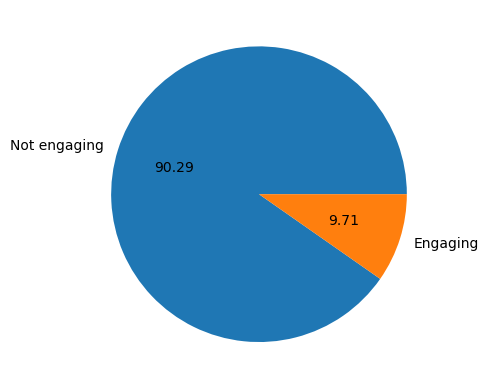

In [5]:
plt.pie(df_train['engagement'].value_counts(),labels=['Not engaging','Engaging'], autopct="%0.2f")
plt.show()

We have an unbalanced dataset

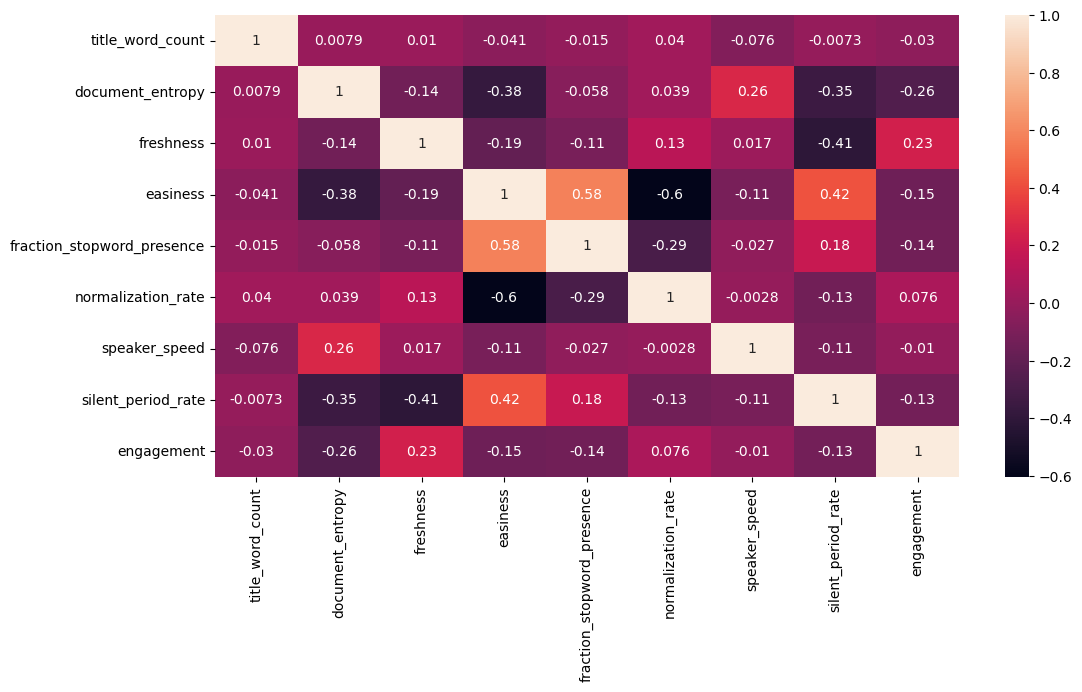

In [18]:
plt.figure(figsize=(12,6))
sns.heatmap(df_train.iloc[:,1:10].corr(), annot=True)
plt.show()

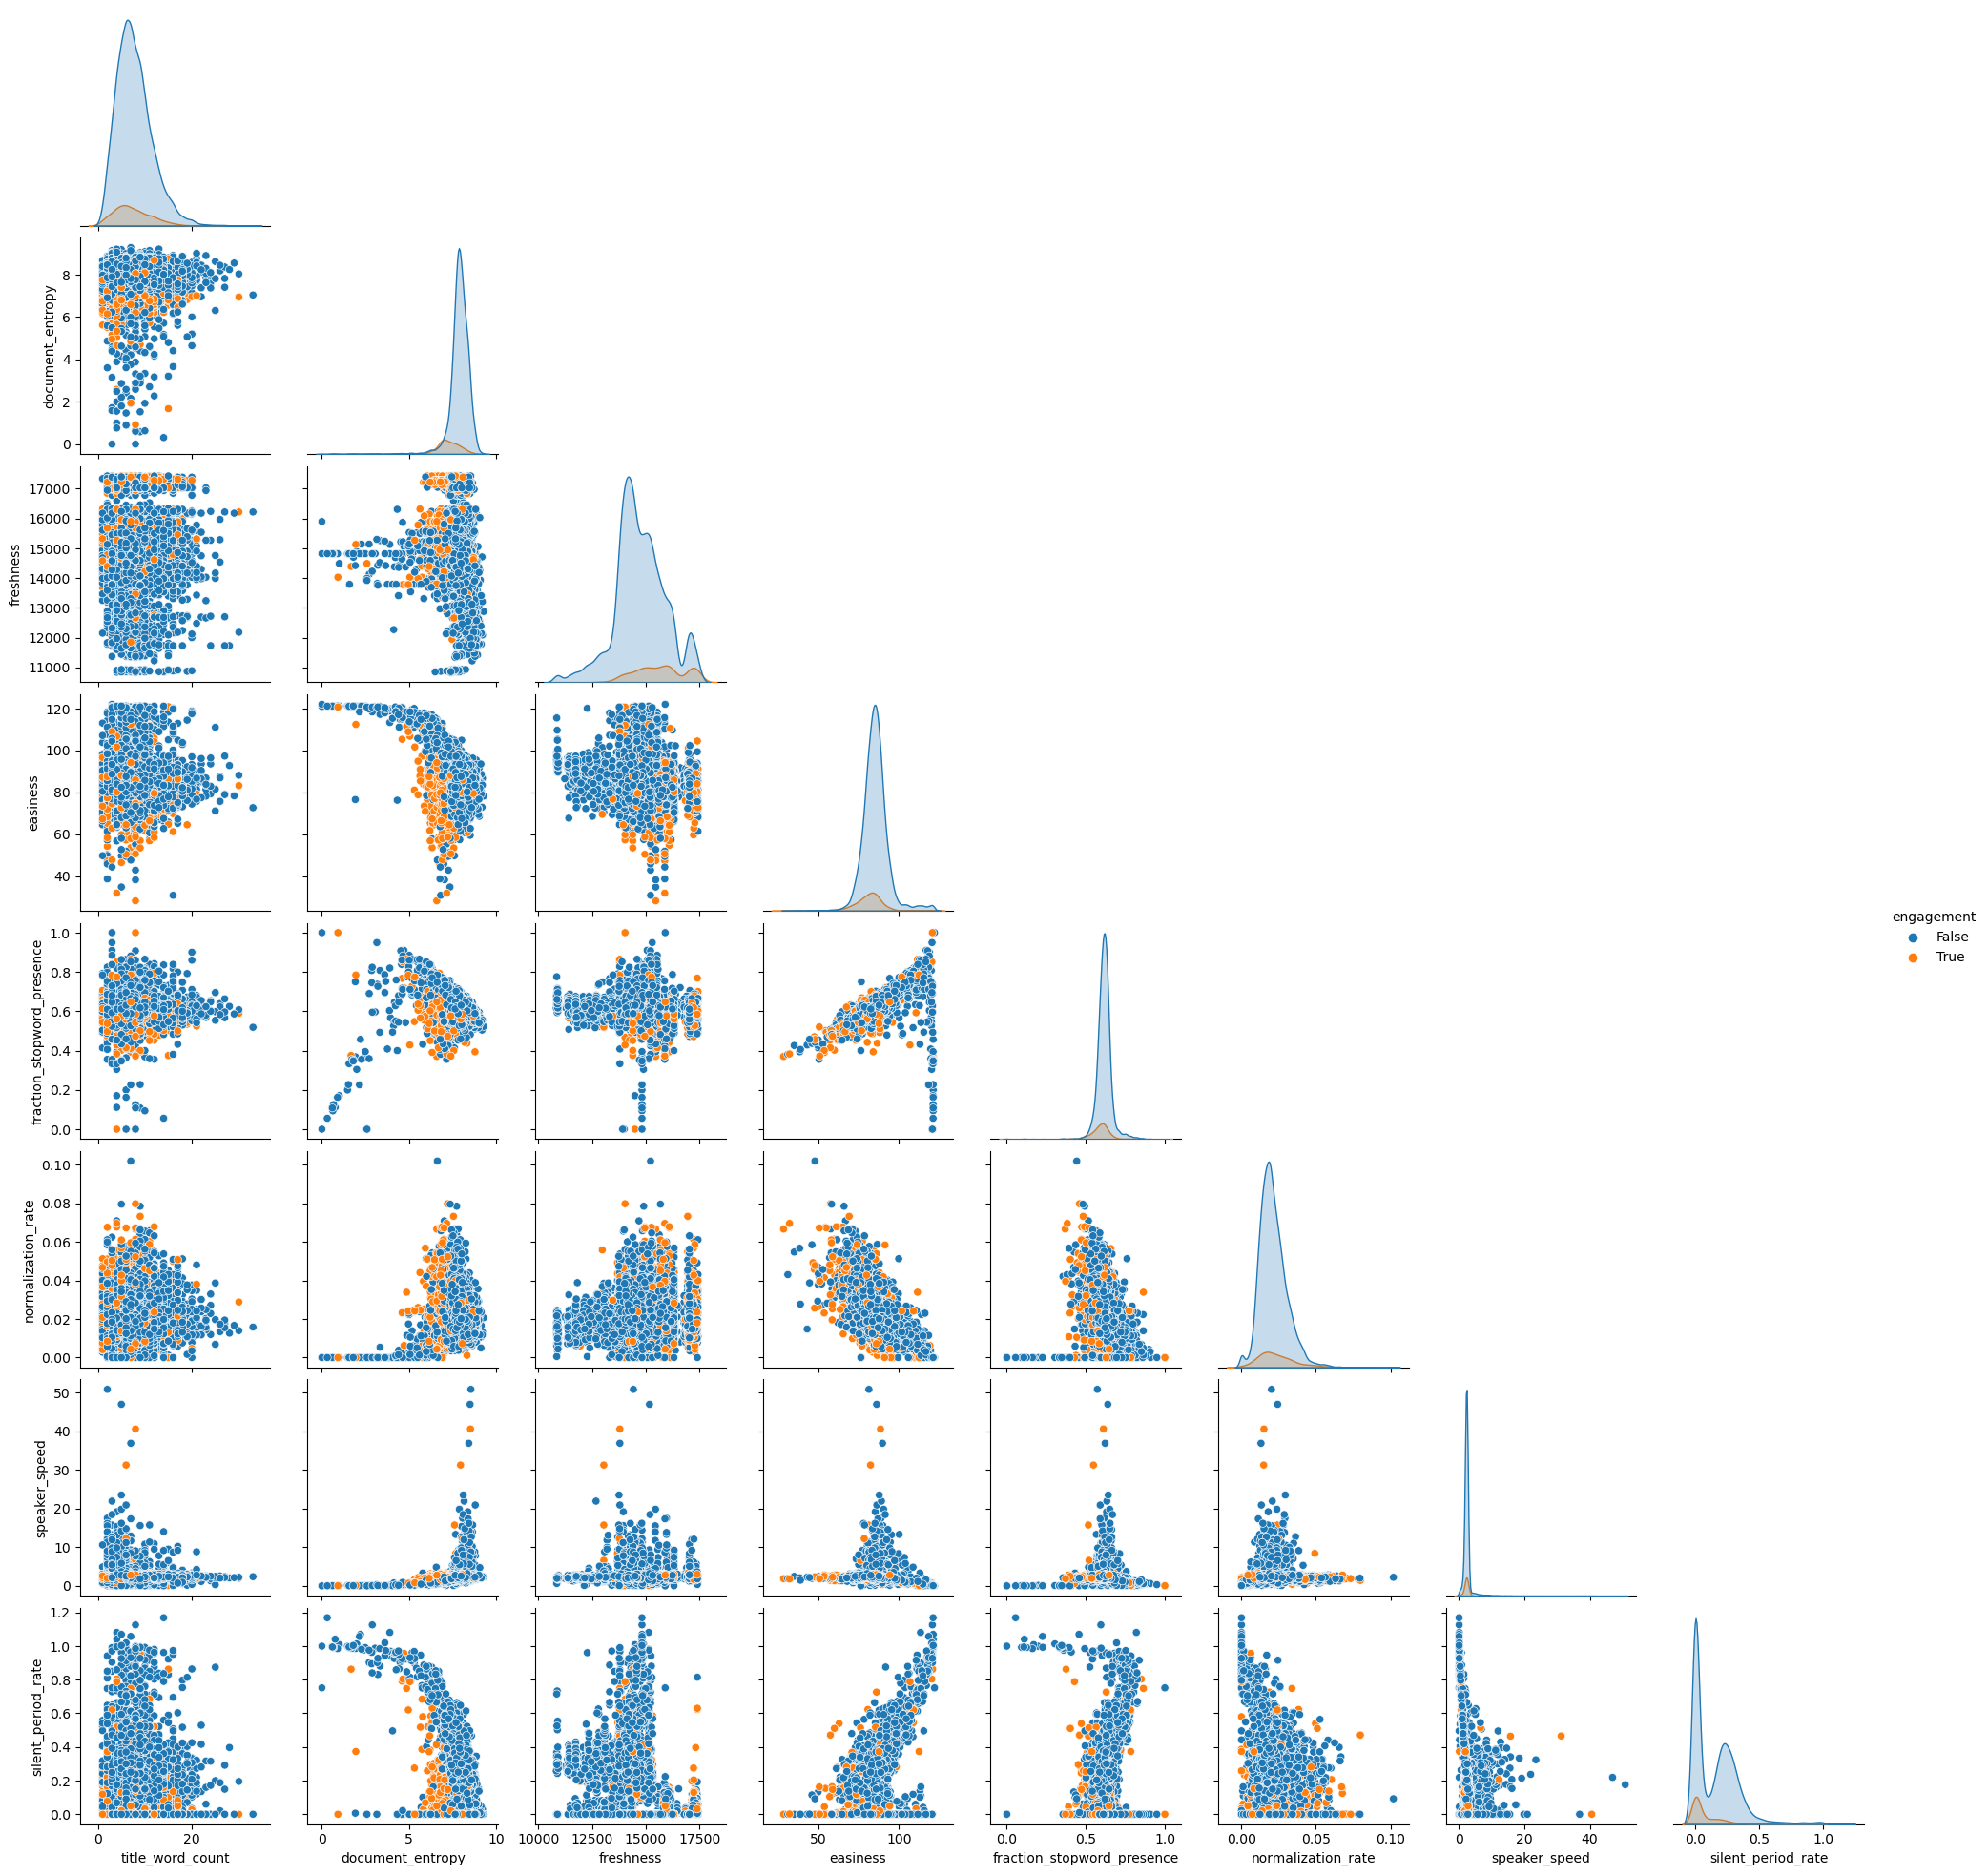

In [19]:
sns.pairplot(data=df_train.iloc[:,1:10], hue='engagement',corner=True)
plt.show()

In [20]:
# definying features and target
features_name=['title_word_count','document_entropy','freshness','easiness','fraction_stopword_presence'
               ,'normalization_rate','speaker_speed','silent_period_rate']
X = df_train[features_name]
y = df_train['engagement']

In [21]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Model Selection

## KNN

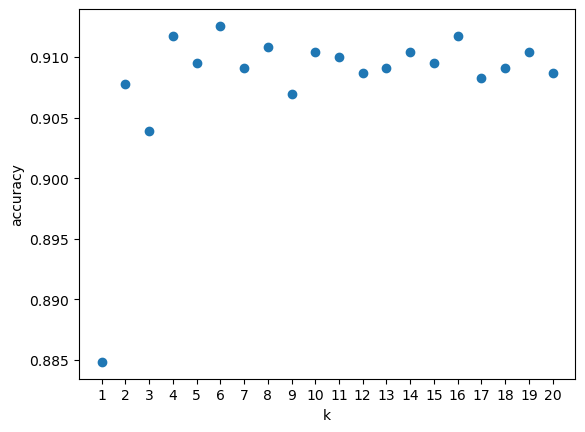

In [98]:
#KNN
k_range = range(1,21)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks(np.arange(1,21))
plt.show()

Accuracy of KNN classifier on training set: 0.93
              precision    recall  f1-score   support

Not engaging       0.92      0.99      0.95      2076
    Engaging       0.71      0.24      0.35       234

    accuracy                           0.91      2310
   macro avg       0.81      0.61      0.65      2310
weighted avg       0.90      0.91      0.89      2310



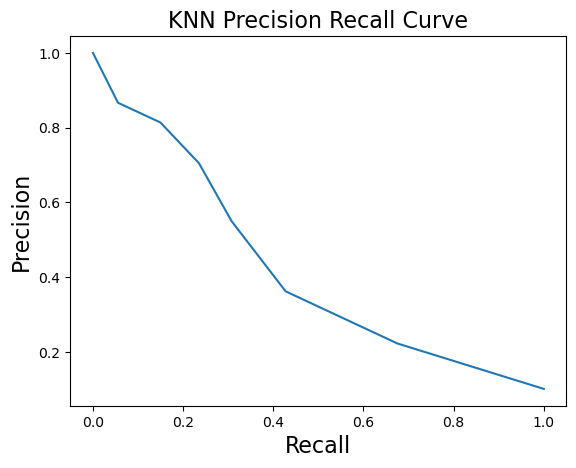

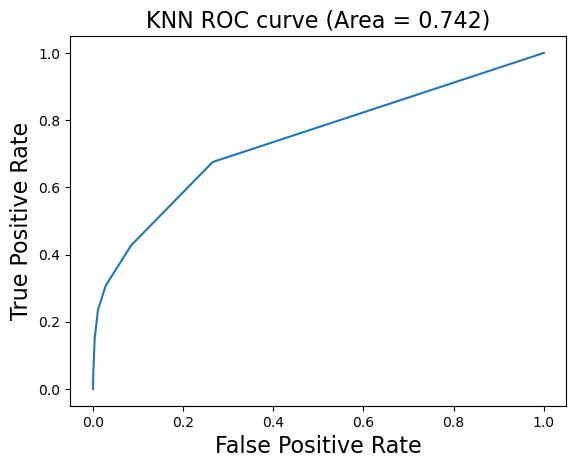

In [60]:
knn = KNeighborsClassifier(n_neighbors = 6).fit(X_train, y_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
y_knn_pred = knn.predict(X_test)
print(classification_report(y_test,y_knn_pred,target_names=['Not engaging','Engaging']))
y_scores_knn = knn.predict_proba(X_test)[:,1]
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_scores_knn)
plt.figure()
plt.plot(recall_knn,precision_knn, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('KNN Precision Recall Curve',fontsize=16)
plt.show()

plt.figure()
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scores_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('KNN ROC curve (Area = {:0.3f})'.format(roc_auc_knn), fontsize=16)
plt.show()

## Decision Tree

Accuracy of DT classifier on training set: 0.96
              precision    recall  f1-score   support

Not engaging       0.94      0.97      0.96      2076
    Engaging       0.66      0.43      0.52       234

    accuracy                           0.92      2310
   macro avg       0.80      0.70      0.74      2310
weighted avg       0.91      0.92      0.91      2310



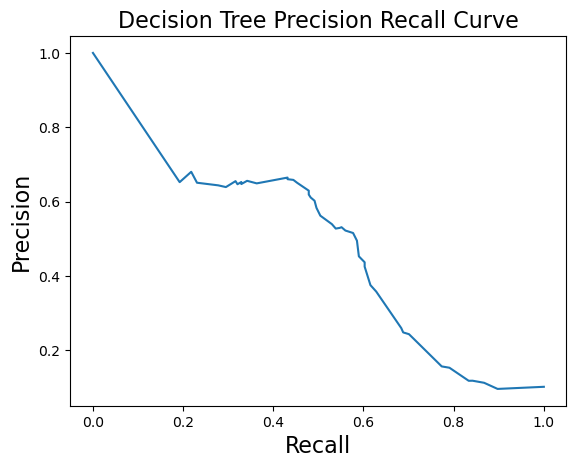

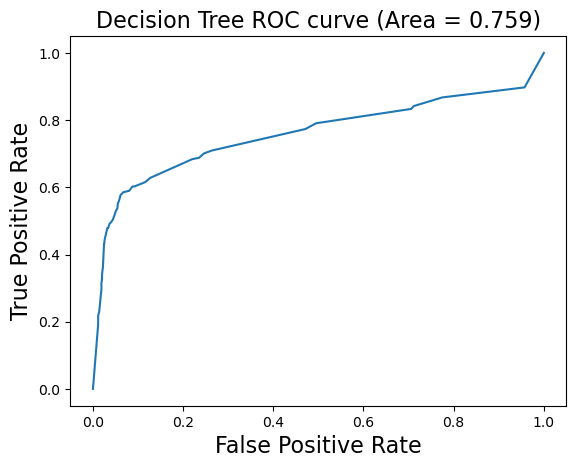

In [61]:
dt_clf = DecisionTreeClassifier(max_depth=8).fit(X_train, y_train)
print('Accuracy of DT classifier on training set: {:.2f}'
     .format(dt_clf.score(X_train, y_train)))
y_dt_pred = dt_clf.predict(X_test)
print(classification_report(y_test,y_dt_pred,target_names=['Not engaging','Engaging']))
y_scores_dt = dt_clf.predict_proba(X_test)[:,1]
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_scores_dt)
plt.figure()
plt.plot(recall_dt,precision_dt, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Decision Tree Precision Recall Curve',fontsize=16)

plt.figure()
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_scores_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Decision Tree ROC curve (Area = {:0.3f})'.format(roc_auc_dt), fontsize=16)
plt.show()

## Random Forest

Accuracy of RF classifier on training set: 1.00
              precision    recall  f1-score   support

Not engaging       0.94      0.98      0.96      2076
    Engaging       0.74      0.44      0.55       234

    accuracy                           0.93      2310
   macro avg       0.84      0.71      0.76      2310
weighted avg       0.92      0.93      0.92      2310



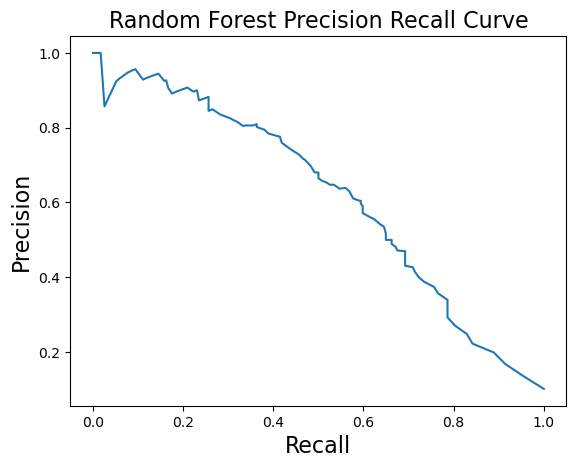

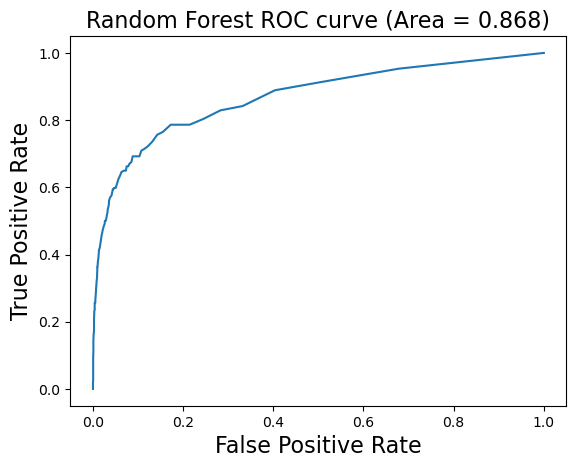

In [62]:
rf_clf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rf_clf.score(X_train, y_train)))
y_rf_pred = rf_clf.predict(X_test)
print(classification_report(y_test,y_rf_pred,target_names=['Not engaging','Engaging']))
y_scores_rf = rf_clf.predict_proba(X_test)[:,1]
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_scores_rf)
plt.figure()
plt.plot(recall_rf,precision_rf, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Random Forest Precision Recall Curve',fontsize=16)

plt.figure()
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_scores_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Random Forest ROC curve (Area = {:0.3f})'.format(roc_auc_rf), fontsize=16)
plt.show()

## Gradient Boosting Classifier

Accuracy of GB classifier on training set: 0.95
              precision    recall  f1-score   support

Not engaging       0.94      0.99      0.96      2076
    Engaging       0.81      0.44      0.57       234

    accuracy                           0.93      2310
   macro avg       0.87      0.72      0.77      2310
weighted avg       0.93      0.93      0.92      2310



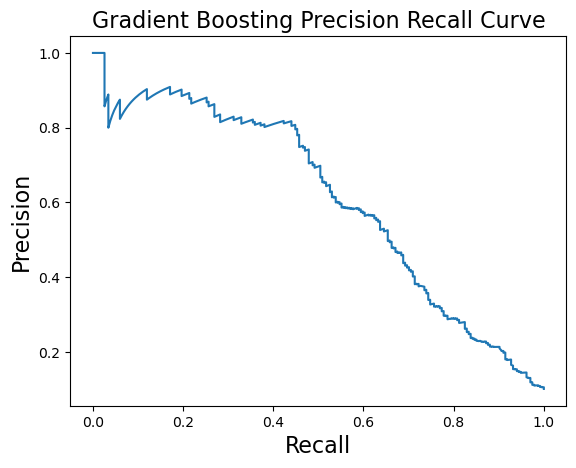

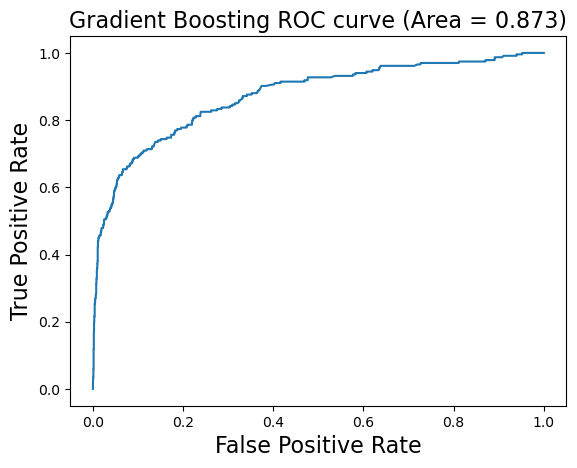

In [63]:
gb_clf = GradientBoostingClassifier(max_features = 8, random_state = 0).fit(X_train, y_train)
print('Accuracy of GB classifier on training set: {:.2f}'
     .format(gb_clf.score(X_train, y_train)))
y_gb_pred = gb_clf.predict(X_test)
print(classification_report(y_test,y_gb_pred,target_names=['Not engaging','Engaging']))
y_scores_gb = gb_clf.predict_proba(X_test)[:,1]
precision_gb, recall_gb,_ = precision_recall_curve(y_test, y_scores_gb)
plt.figure()
plt.plot(recall_gb,precision_gb, label='Precision-Recall Curve')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Gradient Boosting Precision Recall Curve',fontsize=16)

plt.figure()
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_scores_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)
plt.plot(fpr_gb, tpr_gb)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Gradient Boosting ROC curve (Area = {:0.3f})'.format(roc_auc_gb), fontsize=16)
plt.show()

# Comparing Models

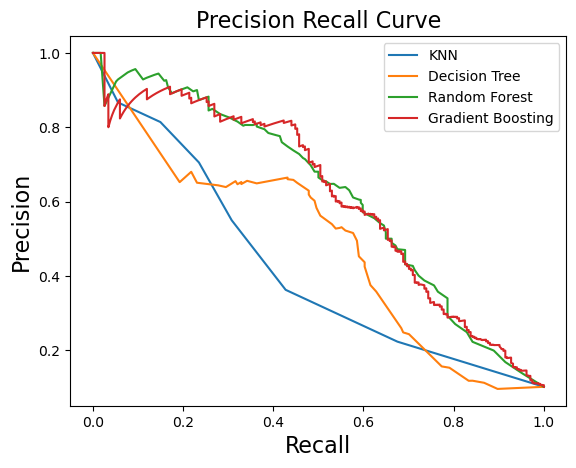

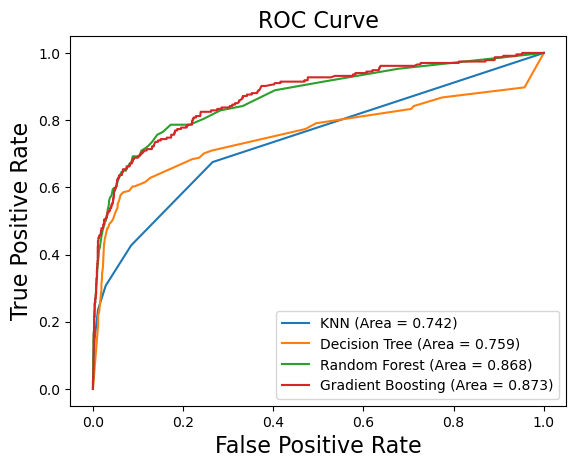

In [67]:
plt.figure()
plt.plot(recall_knn,precision_knn, label='KNN')
plt.plot(recall_dt,precision_dt, label='Decision Tree')
plt.plot(recall_rf,precision_rf, label='Random Forest')
plt.plot(recall_gb,precision_gb, label='Gradient Boosting')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision Recall Curve',fontsize=16)
plt.legend()

plt.figure()
plt.plot(fpr_knn, tpr_knn, label='KNN (Area = {:0.3f})'.format(roc_auc_knn))
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (Area = {:0.3f})'.format(roc_auc_dt))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (Area = {:0.3f})'.format(roc_auc_rf))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (Area = {:0.3f})'.format(roc_auc_gb))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve',fontsize=16)
plt.legend()
plt.show()

# GridSearch
Let's apply GridSearch on Random Forest and Gradient Boosting

## Random Forest

In [70]:
print(rf_clf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [80]:
parameters = {'n_estimators':[100,200,300,400,500]}
grid_rf_auc = GridSearchCV(rf_clf, param_grid = parameters, scoring = 'roc_auc').fit(X_train, y_train)
y_rf_scores_auc = grid_rf_auc.predict_proba(X_test)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, y_rf_scores_auc))
print('Grid best parameter (max. AUC): ', grid_rf_auc.best_params_)
print('Grid best score (AUC): ', grid_rf_auc.best_score_)

Test set AUC:  0.8749917658877198
Grid best parameter (max. AUC):  {'n_estimators': 400}
Grid best score (AUC):  0.888393951163782


## Gradient Boosting

In [81]:
print(gb_clf.get_params())

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 8, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [82]:
parameters = {'n_estimators':[100,200,300,400,500]}

grid_gb_auc = GridSearchCV(gb_clf, param_grid = parameters, scoring = 'roc_auc').fit(X_train, y_train)
y_gb_scores_auc = grid_gb_auc.predict_proba(X_test)[:,1]

print('Test set AUC: ', roc_auc_score(y_test, y_gb_scores_auc))
print('Grid best parameter (max. AUC): ', grid_gb_auc.best_params_)
print('Grid best score (AUC): ', grid_gb_auc.best_score_)

Test set AUC:  0.8810850089751825
Grid best parameter (max. AUC):  {'n_estimators': 300}
Grid best score (AUC):  0.8915997035768436


# Predicting a different dataset

In [91]:
df_test

,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate
0,9240,6,8.548351,14140,89.827395,0.640810,0.017945,2.262723,0.000000
1,9241,8,7.730110,14600,82.446667,0.606738,0.027708,2.690351,0.000000
2,9242,3,8.200887,16980,88.821542,0.621089,0.009857,3.116071,0.000000
3,9243,5,6.377299,16260,86.874660,0.600000,0.004348,2.837500,0.017994
4,9244,18,7.756530,14030,88.872277,0.616105,0.033240,1.354839,0.000000
...,...,...,...,...,...,...,...,...,...
2304,11544,11,7.781813,13920,80.620236,0.611722,0.031276,2.193125,0.194918
2305,11545,3,7.800766,13990,94.080225,0.654741,0.013967,1.580000,0.338601
2306,11546,2,8.235828,14280,95.173070,0.618686,0.018486,5.548518,0.369348
2307,11547,13,6.775492,15900,74.053098,0.560472,0.032448,2.592308,0.005131


In [96]:
gb_clf = GradientBoostingClassifier(n_estimators = 300, max_features = 8, random_state = 0).fit(X_train, y_train)
X_test_data = df_test.iloc[:,1:9]
y_pred = gb_clf.predict_proba(X_test_data)
df_proba = pd.DataFrame(data = y_pred[:,1], columns=['Probability of being Engaging'],index = df_test['id'])
df_proba

,Probability of being Engaging
id,
9240,0.006791
9241,0.042303
9242,0.162506
9243,0.998325
9244,0.003477
...,...
11544,0.021040
11545,0.006239
11546,0.007847
